# Imports

In [1]:
import re
import nltk
import string
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm import tqdm
from chatbot.transformer import Transformer

colors = ['#346aa6', '#6699d3', '#2aa882', '#5dd3b0', '#ffb440', '#ff8240', '#f66b89', '#ec3b61']
c_pal = sns.set_palette(sns.color_palette(colors))
SEED = 42
stopword = nltk.corpus.stopwords.words('english')
wn = nltk.WordNetLemmatizer()
ps = nltk.PorterStemmer()
words = set(nltk.corpus.words.words())

# Data preprocessing

## Load

In [2]:
def show_plot(df: pd.DataFrame, field:str = 'emotion', rot: int = 45, xsize:int=20):
    plt.figure(figsize = [xsize, 8])
    sns.countplot(x=df[field], palette=c_pal)
    plt.xticks(rotation=rot, size=15)
    plt.yticks(size=15)
    plt.ylabel('Amount', size=20)
    plt.xlabel(field.title(), size=20)
    plt.show()

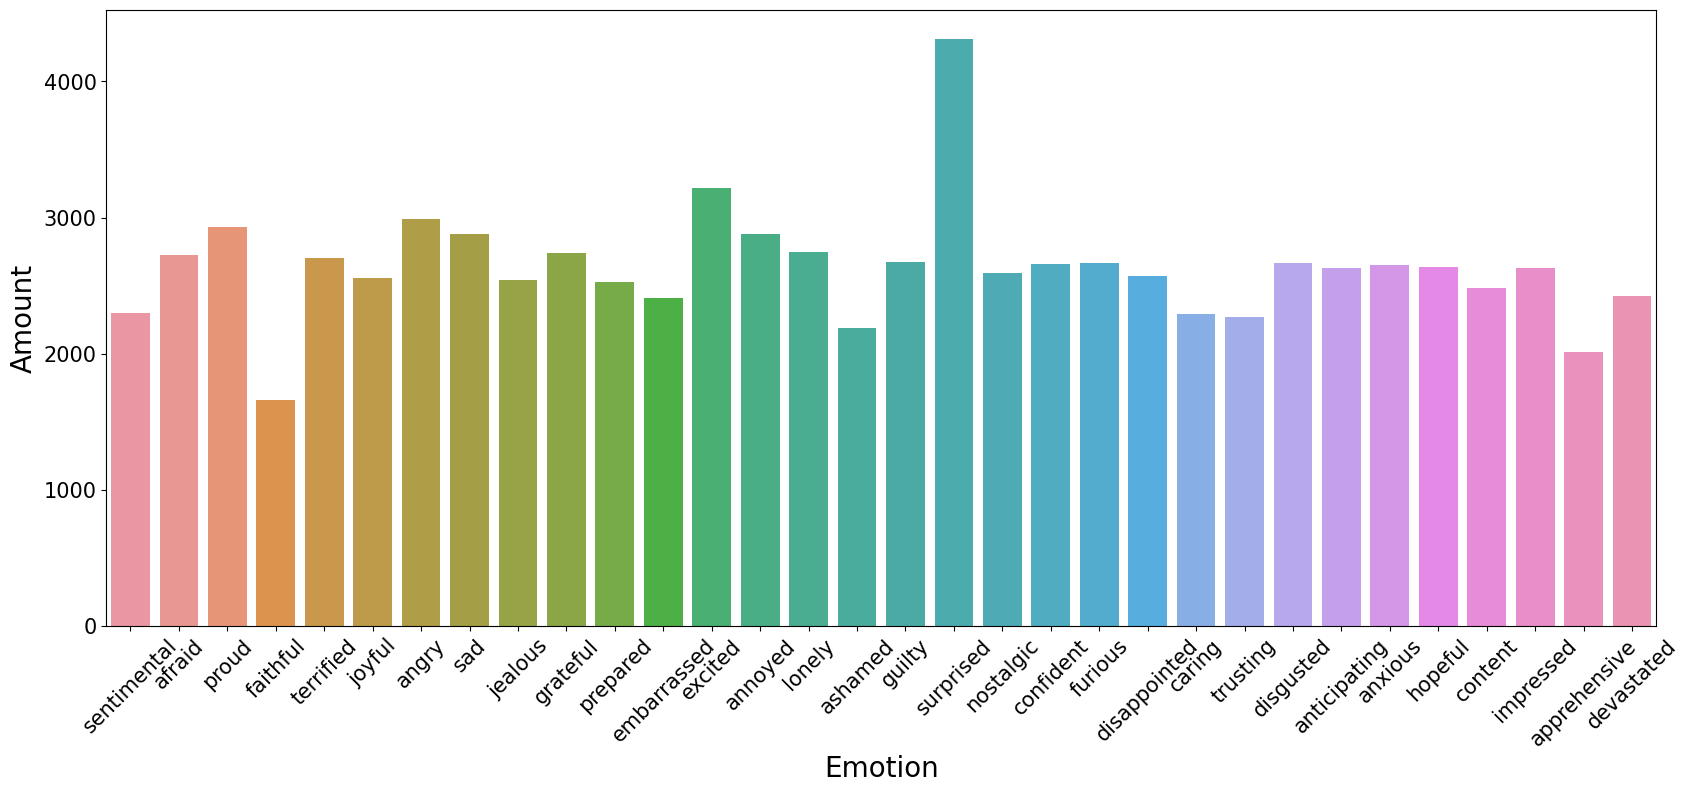

In [3]:
df = pd.read_csv('data/training_dataset.csv', sep=';')
show_plot(df)

## Filtering

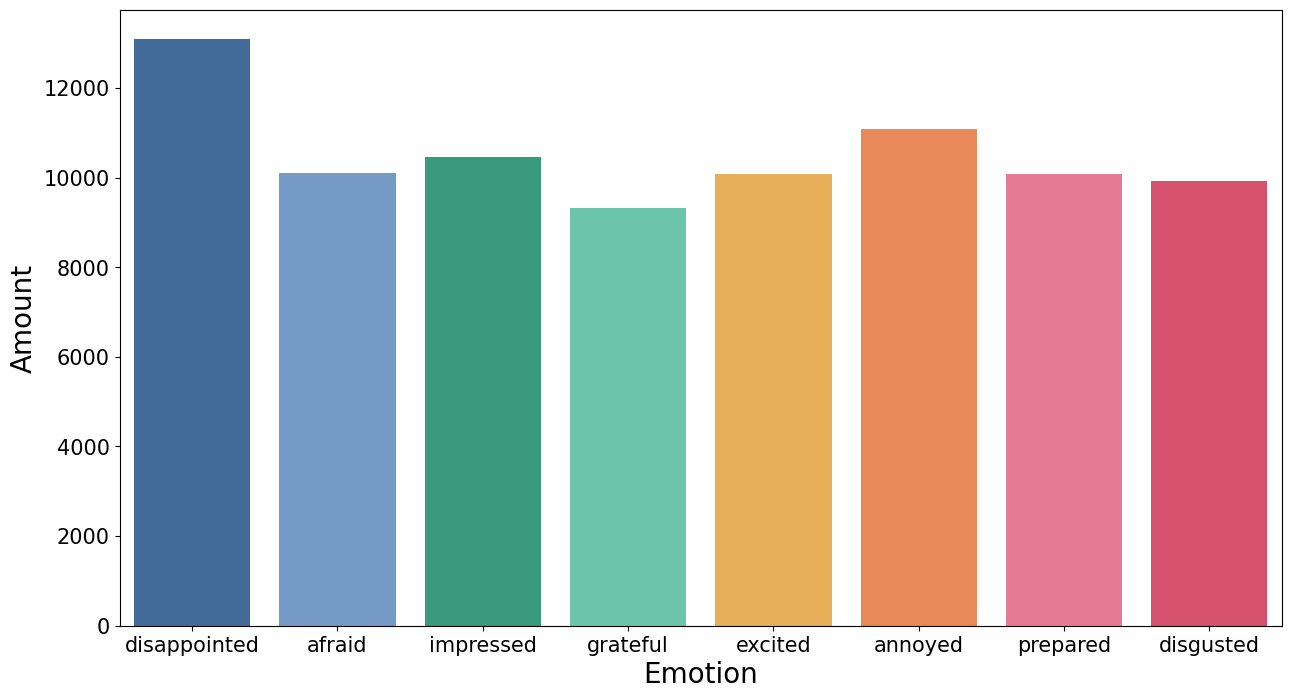

In [4]:
df.loc[df['emotion'] == 'surprised', 'emotion'] = 'excited'
df.loc[df['emotion'] == 'joyful', 'emotion'] = 'excited'

df.loc[df['emotion'] == 'terrified', 'emotion'] = 'afraid'
df.loc[df['emotion'] == 'anxious', 'emotion'] = 'afraid'
df.loc[df['emotion'] == 'apprehensive', 'emotion'] = 'afraid'

df.loc[df['emotion'] == 'embarrassed', 'emotion'] = "disgusted"
df.loc[df['emotion'] == 'guilty', 'emotion'] = "disgusted"
df.loc[df['emotion'] == 'ashamed', 'emotion'] = "disgusted"

df.loc[df['emotion'] == 'angry', 'emotion'] = "annoyed"
df.loc[df['emotion'] == 'jealous', 'emotion'] = "annoyed"
df.loc[df['emotion'] == 'furious', 'emotion'] = "annoyed"

df.loc[df['emotion'] == 'faithful', 'emotion'] = "grateful"
df.loc[df['emotion'] == 'caring', 'emotion'] = "grateful"
df.loc[df['emotion'] == 'hopeful', 'emotion'] = "grateful"

df.loc[df['emotion'] == 'sad', 'emotion'] = "disappointed"
df.loc[df['emotion'] == 'lonely', 'emotion'] = "disappointed"
df.loc[df['emotion'] == 'nostalgic', 'emotion'] = "disappointed"
df.loc[df['emotion'] == 'sentimental', 'emotion'] = "disappointed"

df.loc[df['emotion'] == 'devastated', 'emotion'] = "impressed"
df.loc[df['emotion'] == 'proud', 'emotion'] = "impressed"
df.loc[df['emotion'] == 'content', 'emotion'] = "impressed"

df.loc[df['emotion'] == 'trusting', 'emotion'] = "prepared"
df.loc[df['emotion'] == 'anticipating', 'emotion'] = "prepared"
df.loc[df['emotion'] == 'confident', 'emotion'] = "prepared"
show_plot(df, rot = 0, xsize=15)

## Downsampling

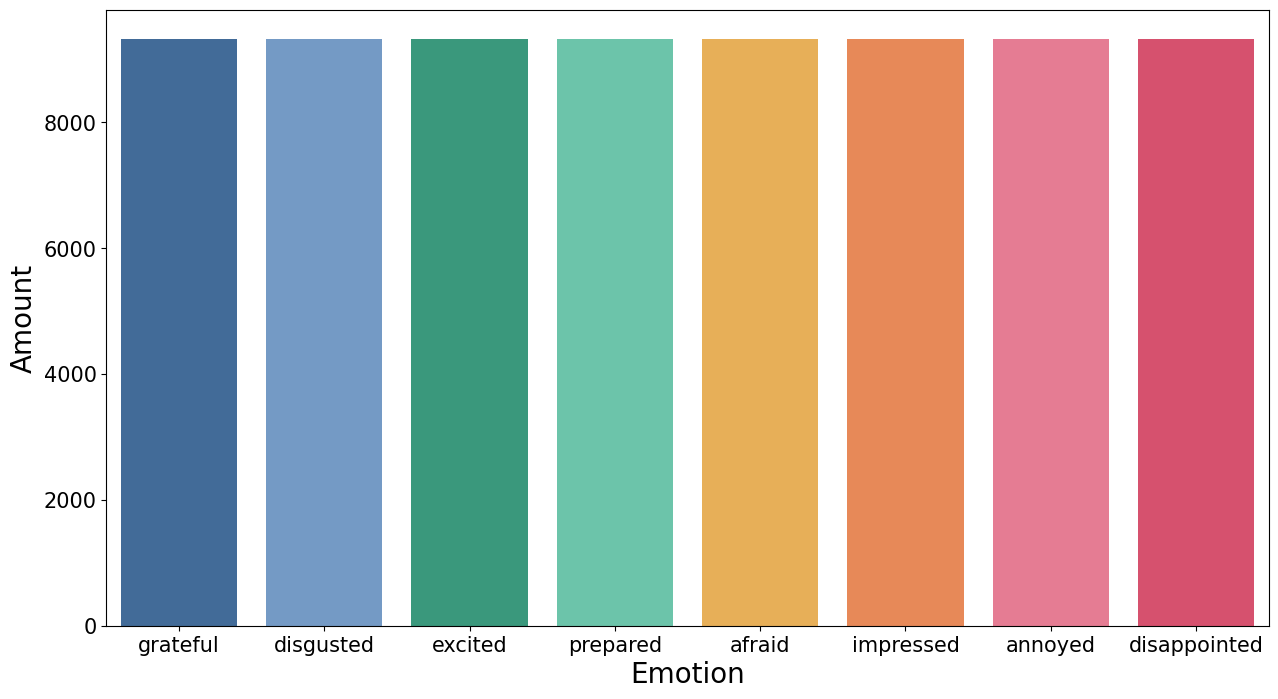

In [5]:

selected_categories = list(df['emotion'].unique())
selected_df = df[df['emotion'].isin(selected_categories)]
df_downsample = df[df['emotion'] == selected_df['emotion'].value_counts().sort_values().index[0]].sample(n=selected_df['emotion'].value_counts().sort_values()[0], random_state=SEED)
for i in range(len(selected_df['emotion'].unique()) - 1):
    df_downsample = pd.concat(
        [
            df_downsample, 
            df[df['emotion'] == selected_df['emotion'].value_counts().sort_values().index[i + 1]].sample(n=selected_df['emotion'].value_counts().sort_values()[0], random_state=SEED)
        ]
    )

show_plot(df_downsample, rot = 0, xsize=15)

## Context classification

### Prepare data

In [6]:
init_df: pd.DataFrame = pd.read_csv('data/categories_dataset.csv', sep=';')

SC = list(init_df['category'].unique())
selected_df_1 = init_df[init_df['category'].isin(SC)]
df_downsample_cat = init_df[init_df['category'] == selected_df_1['category'].value_counts().sort_values().index[0]].sample(n=selected_df_1['category'].value_counts().sort_values()[0], random_state=SEED)
for i in range(len(selected_df_1['category'].unique()) - 1):
    df_downsample_cat = pd.concat(
        [
            df_downsample_cat, 
            init_df[init_df['category'] == selected_df_1['category'].value_counts().sort_values().index[i + 1]].sample(n=selected_df_1['category'].value_counts().sort_values()[0], random_state=SEED)
        ]
    )

In [7]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"www.\S+", "", text)
    text_links_removed = "".join([char for char in text if char not in string.punctuation])
    text_cleaned = " ".join([word for word in re.split('\W+', text_links_removed)
        if word not in stopword])
    text = " ".join([wn.lemmatize(word) for word in re.split('\W+', text_cleaned)])
    return text

df_downsample['ft_q'] = df_downsample['question'].map(lambda x: clean_text(x))
df_downsample_cat["text"] = df_downsample_cat["headline"]
df_downsample_cat['text'] = df_downsample_cat['text'].map(lambda x: clean_text(x))
X, y = df_downsample_cat['text'], df_downsample_cat["category"]

X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(df_downsample_cat['text'], df_downsample_cat['category'], test_size=0.2, stratify=df_downsample_cat['category'])

le = sk.preprocessing.LabelEncoder()
le.fit(SC)
y_train_label = le.transform(y_train)
y_test_label = le.transform(y_test)

tf_idf_vectorizer = sk.feature_extraction.text.TfidfVectorizer()
X_train_t = tf_idf_vectorizer.fit_transform(X_train)
X_test_t = tf_idf_vectorizer.transform(X_test)

In [8]:
maxlen = 200
oov_token = "<oov_token>"
tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token = oov_token)
tokenizer.fit_on_texts(df_downsample_cat.text.to_list()+df_downsample.ft_q.to_list()) 

word_index = {}
word_index = tokenizer.word_index
vocabulary = len(word_index) +1
                                            
X_tokenizer = tokenizer.texts_to_sequences(df_downsample_cat.text.to_list())
X_predict = tokenizer.texts_to_sequences(df_downsample.ft_q.to_list())
X_padded = tf.keras.preprocessing.sequence.pad_sequences(X_tokenizer, maxlen=maxlen, truncating='post',padding='pre')
X_predict_padded = tf.keras.preprocessing.sequence.pad_sequences(X_predict, maxlen=maxlen, truncating='post',padding='pre')

Y = pd.get_dummies(df_downsample_cat['category'].values)

X_train_padded, X_test_padded, Y_train_dummy, Y_test_dummy = sk.model_selection.train_test_split(X_padded, Y, test_size=0.2, random_state=SEED)

### Import GLOVE

In [9]:
glove_dictionary = {}
with open('data/glove.6B.200d.txt',encoding="utf8") as file:
    for each_line in file:
        words_in_line, coeff_cients = each_line.split(maxsplit=1)
        coeff_cients = np.array(coeff_cients.split(),dtype = float)
        glove_dictionary[words_in_line] = coeff_cients

embedding_matrix = np.zeros((vocabulary, maxlen))
for word, i in word_index.items():
    embedding_vector = glove_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

### Train Model

In [10]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Embedding(vocabulary, 200, weights=[embedding_matrix], input_length=maxlen))
model.add(tf.keras.layers.LSTM(128))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(32, activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(len(SC), activation='sigmoid'))

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=['AUC', 'Recall', 'Precision', 'accuracy'])

# train and validate the model on the padded sequences of text which we have created initially       
model.fit(
    X_train_padded, 
    Y_train_dummy, 
    epochs=110, 
    verbose=1,
    batch_size=64,
    validation_split=0.1,
    validation_data=(
        X_test_padded, 
        Y_test_dummy
        )
    )

Epoch 1/110
1114/1114 [==============================] - 35s 29ms/step - loss: 2.1753 - auc: 0.5640 - recall: 0.6199 - precision: 0.1271 - accuracy: 0.1472 - val_loss: 2.1163 - val_auc: 0.6804 - val_recall: 0.7724 - val_precision: 0.1520 - val_accuracy: 0.2618
Epoch 2/110
1114/1114 [==============================] - 32s 29ms/step - loss: 2.0604 - auc: 0.6851 - recall: 0.7683 - precision: 0.1546 - accuracy: 0.2703 - val_loss: 1.9631 - val_auc: 0.7615 - val_recall: 0.8471 - val_precision: 0.1667 - val_accuracy: 0.4075
Epoch 3/110
1114/1114 [==============================] - 32s 29ms/step - loss: 1.8971 - auc: 0.7474 - recall: 0.8329 - precision: 0.1681 - accuracy: 0.3671 - val_loss: 1.7555 - val_auc: 0.8074 - val_recall: 0.8950 - val_precision: 0.1748 - val_accuracy: 0.4690
Epoch 4/110
1114/1114 [==============================] - 33s 29ms/step - loss: 1.7246 - auc: 0.7847 - recall: 0.8676 - precision: 0.1758 - accuracy: 0.4246 - val_loss: 1.5688 - val_auc: 0.8383 - val_recall: 0.9183 - v

In [17]:
df_downsample['category'] = [SC[int(tf.argmax(i).numpy())] for i in model.predict(X_predict_padded, verbose=1)]
df_downsample = df_downsample[['question', 'answer', 'emotion', 'category']]

2332/2332 [==============================] - 21s 9ms/step


In [18]:
df_downsample.head(7)
df_downsample.to_csv('data/dataset.csv', index=None, sep=';')

,question,answer,emotion,category
78172,I put a bid in for a new house! I don't know y...,Last week I put in a bid to purchase my first ...,grateful,SPORTS
21712,I had a bad day at work and my girlfriend made...,Well i am so glad my girlfriend was there when...,grateful,BUSINESS
63520,I'm going to cooking school to become a chef.,That's pretty cool. Maybe you could toss me a ...,grateful,BUSINESS
33812,I'm faithful I'm going down the right career p...,man thats awesome_comma_ i have a friend who i...,grateful,MINORITIES
71069,One time while I was working an employee came ...,It's terrible when people can't take no for an...,grateful,ENTERTAINMENT
7060,I pray I pass the bar exam next week.,No I take it next week.,grateful,POLITICS
50337,A coworker helped me move to another city. He ...,No_comma_ I sold the heavy appliances before m...,grateful,ENTERTAINMENT


# Transformer

In [ ]:
from chatbot.transformer import Transformer
data = pd.read_csv('data/dataset.csv', sep=';')
model = Transformer(num_epoch=100)

## Additional classificators training

In [ ]:
model.fit_data(data=data)
model.train_classificators()

## Main model training

In [ ]:
# history = model.compile_model()

In [ ]:
# import pickle 
# history = dict(history)
# with open('trained_models/transformer/history.pkl', 'wb') as f:
#     pickle.dump(history, f)

In [ ]:
# model.save_to_folder('trained_models/transformer/')